# Implementation LSTM model for Forecasting
### 'My Stock Forecast App' 

In [19]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [21]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## DATA INGESTION

In [22]:
# Input dari pengguna untuk simbol saham
symbol = input("Input simbol saham (e.g 'BBRI.JK'): ")
start_date = date(2019, 1, 1)
end_date = date(2024, 3, 31)

# Mengunduh data saham dari Yahoo Finance # Menambahkan kolom tanggal sebagai indeks
data = yf.download(symbol, start=start_date, end=end_date)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [23]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3327.215332,3327.215332,3327.215332,3327.215332,2594.004150,0
2019-01-02,3281.761475,3309.033691,3263.580078,3281.761475,2558.566650,82441033
2019-01-03,3254.489258,3309.033691,3254.489258,3290.852295,2565.654053,102805905
2019-01-04,3290.852295,3327.215332,3281.761475,3327.215332,2594.004150,125907734
2019-01-07,3363.578369,3372.668945,3327.215332,3327.215332,2594.004150,82106628


In [24]:
data.reset_index(inplace=True)

# Input dari pengguna untuk fitur yang akan digunakan
input_feat = input("Masukkan fitur yang akan digunakan ('Adj Close','Close'): ")

data = data[["Date", input_feat]]
data

,Date,Close
0,2019-01-01,3327.215332
1,2019-01-02,3281.761475
2,2019-01-03,3290.852295
3,2019-01-04,3327.215332
4,2019-01-07,3327.215332
...,...,...
1285,2024-03-22,6125.000000
1286,2024-03-25,6250.000000
1287,2024-03-26,6300.000000
1288,2024-03-27,6250.000000


## DATA PROCESSING

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

In [26]:
# Pembagian data menjadi data training dan data testing
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

In [27]:
# Persiapan Create Sequences LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [28]:
tf.random.set_seed(7)

In [29]:
sequence_length = 1
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Modelling

In [30]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 50)             10400     
                                                                 
 dropout_3 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

# Training


In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Train the model
model_final = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, 
                         callbacks=[early_stopping], 
                         validation_data=(X_test, y_test))

Epoch 1/100
33/33 - 8s - loss: 0.1407 - accuracy: 9.6993e-04 - val_loss: 0.2816 - val_accuracy: 0.0000e+00 - 8s/epoch - 231ms/step
Epoch 2/100
33/33 - 0s - loss: 0.0217 - accuracy: 9.6993e-04 - val_loss: 0.0790 - val_accuracy: 0.0039 - 447ms/epoch - 14ms/step
Epoch 3/100
33/33 - 0s - loss: 0.0117 - accuracy: 9.6993e-04 - val_loss: 0.0511 - val_accuracy: 0.0039 - 420ms/epoch - 13ms/step
Epoch 4/100
33/33 - 0s - loss: 0.0095 - accuracy: 9.6993e-04 - val_loss: 0.0339 - val_accuracy: 0.0039 - 445ms/epoch - 13ms/step
Epoch 5/100
33/33 - 0s - loss: 0.0072 - accuracy: 9.6993e-04 - val_loss: 0.0157 - val_accuracy: 0.0039 - 429ms/epoch - 13ms/step
Epoch 6/100
33/33 - 0s - loss: 0.0046 - accuracy: 9.6993e-04 - val_loss: 0.0028 - val_accuracy: 0.0039 - 443ms/epoch - 13ms/step
Epoch 7/100
33/33 - 0s - loss: 0.0035 - accuracy: 9.6993e-04 - val_loss: 7.5844e-04 - val_accuracy: 0.0039 - 451ms/epoch - 14ms/step
Epoch 8/100
33/33 - 0s - loss: 0.0030 - accuracy: 9.6993e-04 - val_loss: 0.0031 - val_accur

# Evaluation

In [32]:
loss = model.evaluate(X_test, y_test)
round_loss = [round(num, 5) for num in loss]
print("Loss :", round_loss)

predict = model.predict(X_test)
# print(predict)
predict = scaler.inverse_transform(predict)
# print(predict)

9/9 [==============================] - 0s 5ms/step - loss: 7.5844e-04 - accuracy: 0.0039
Loss : [0.00076, 0.00389]
9/9 [==============================] - 1s 5ms/step


In [33]:
print("-"*15, " Metric ","-"*15)
print('RMSE : ', round(sqrt(metrics.mean_squared_error(y_test, predict)), 5))
print('MSE  : ', round(abs(metrics.mean_squared_error(y_test, predict)), 5))
print('MAE  : ', round(metrics.mean_absolute_error(y_test, predict), 5))

---------------  Metric  ---------------
RMSE :  5406.03151
MSE  :  29225176.71299
MAE  :  5386.58754


## Plot Loss

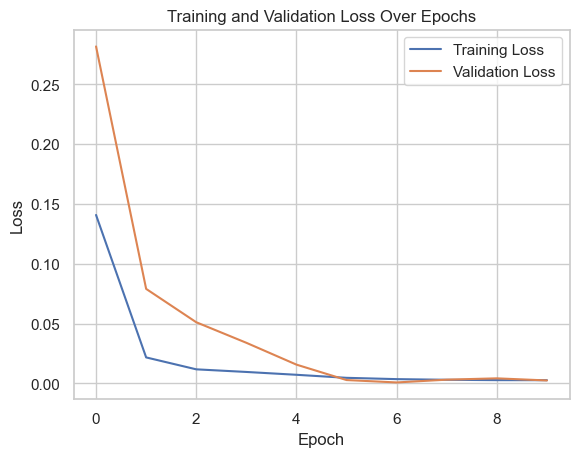

In [34]:
# Plot loss
sns.set(style="whitegrid")

sns.lineplot(x=range(len(model_final.history['loss'])), y=model_final.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(model_final.history['val_loss'])), y=model_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Saving Model

In [35]:
import time

ts = int(time.time())
file_path = f"../lstm_stock/{ts}/"
model.save(filepath=file_path, save_format='tf')
print("Sucess saving model!")

INFO:tensorflow:Assets written to: ../lstm_stock/1713694047/assets


INFO:tensorflow:Assets written to: ../lstm_stock/1713694047/assets


Sucess saving model!
